# Система рекомендаций для Spotify

**Проблематика**

В связи с **огромным ростом** числа **платформ** для потоковой передачи музыки **пользователи часто сталкиваются с проблемой** поиска новых песен, соответствующих их предпочтениям. Используя методы машинного обучения, этот проект стремится решить эту проблему путем создания персонализированной системы рекомендаций.

**Решение**

**Проект**, который, используя методы машинного обучения, **постарается решить** эту **проблему** путем создания персонализированной системы рекомендаций.

**Цель**

Разработать **надежную и эффективную** систему рекомендаций песен, чтобы **повысить удовлетворенность и вовлеченность** пользователей путем предоставления **точных и релевантных** предложений песен, тем самым **улучшая** общий **опыт** прослушивания музыки пользователями.

Подготовил: Марченко Дмитрий Сергеевич, РИ-230931

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotisy-ds/dataset.csv


Импортируем библиотеки

In [2]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from copy import copy
import warnings
warnings.filterwarnings("ignore")
#%matplotlib inline 
#раскомментировать при надобности

Считаем датасет

In [3]:
df = pd.read_csv("/kaggle/input/spotisy-ds/dataset.csv")

# Описание данных датасета

**Значение столбцов:**

* track_id: lD трека
* artists: Имена артистов, исполняющих трек. (Если несколько, разделяются знаком ";")
* album_name: Название альбома, в котором песня была выпущена
* track_name: Название трека
* popularity: Популярность трека — значение от 0 до 100. **Целевая переменная**
* duration_ms: Длительность трека в миллисекундах
* explicit: Является ли текст трека откровенным (true = да; false = нет, неизвестно)
* danceability: Описывает то, насколько трек подходит для танцев.
* energy: Мера интенсивности и активности трека
* kеу: Тональность трека
* loudness: Показатель громкости песни
* mode: Режим аудиозаписи
* speechiness: Показатель "красноречивости" текста в песне
* acousticness: Показатель качества зачество авука
* instrumentalness: Показатель плотности звучания инструментов в треке
* liveness: Показатель живости трека
* valence: Показатель привлекательности звуков трека для слуха
* tеmpо: Темп трека, указыватся в ВРМ (удары в минуту)
* time_signature: Указывает на то, сколько ударов приходится на каждый такт трека
* track_genre: Жанр трека

Выведем датасет 

In [4]:
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


Рассмотрим информацию о датасете, видим, что в нем 114000 песен

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

Рассмотрим различные метрики целевой переменной

In [6]:
df["popularity"].describe()

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

Исходя из этой информации запишем диапазон значений в описание датасета

# Подготовка к анализу

**Проверка и избавление от NaN**

Видим 3 NaN значения, решаем сразу их удалить (они не повлияют на нашу огромную выборку в 114000 значений)

In [7]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [8]:
df = df.dropna()

Проверяем,что все прошло успешно

In [9]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Удаляем "Unnamed:" и "track_id", потому что они не дают нам полезной (для нашей задачи) информации

In [10]:
df.drop(['Unnamed: 0','track_id'], inplace=True, axis=1) 

Проверяем, что все прошло успешно

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  object 
 1   album_name        113999 non-null  object 
 2   track_name        113999 non-null  object 
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  bool   
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

Измерять длительность песни в милисекундах неудобно, переведем ее в минуты

In [12]:
df['duration_ms'] = df['duration_ms'].apply(lambda time: round(time/60000,1))

df = df.rename(columns={'duration_ms':'duration_min'})


Посмотрим, что у нас вышло

In [13]:
df["duration_min"].describe()

count    113999.000000
mean          3.800503
std           1.788433
min           0.100000
25%           2.900000
50%           3.500000
75%           4.400000
max          87.300000
Name: duration_min, dtype: float64

Избавимся от типа данных object

In [14]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Во время обучения числовые типы данных предпочтительнее, чем булевые, изменим тип данных explicit на int

In [15]:
df['explicit'] = df['explicit'].astype(int)

Проверим, что все сработало

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  int64  
 1   album_name        113999 non-null  int64  
 2   track_name        113999 non-null  int64  
 3   popularity        113999 non-null  int64  
 4   duration_min      113999 non-null  float64
 5   explicit          113999 non-null  int64  
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

Отлично

Рассмотрим, есть ли в датасете перекос по жанрам

In [17]:
print(df['track_genre'].value_counts())

track_genre
0      1000
1      1000
84     1000
83     1000
82     1000
       ... 
33     1000
32     1000
31     1000
113    1000
65      999
Name: count, Length: 114, dtype: int64


Нет, его нет

# Итоги подготовки
* Мы избавились от NaN значений и изменили данные датасета так, чтобы в нем остались только числовые данные
* Данные подготовлены к поседующему анализу


# Корреляционная матрица

* fmt='.2f' - оставляем 2 цифры после "."
* cmap='coolwarm' - цветовая схема матрицы
* annot=True - показываем значение корреляции в каждой ячейке

Гипотеза - большое количество треков с популярностью 0 может создавать коллизию
Проверю это.

In [18]:
#df = df[df['popularity'] > 0]

Итог - это незначительно повлияло на корреляцию, зато при удалении может появиться дисбаланс после удаления треков с 0 популярностью
Решил не удалять песни с 0 популярностью

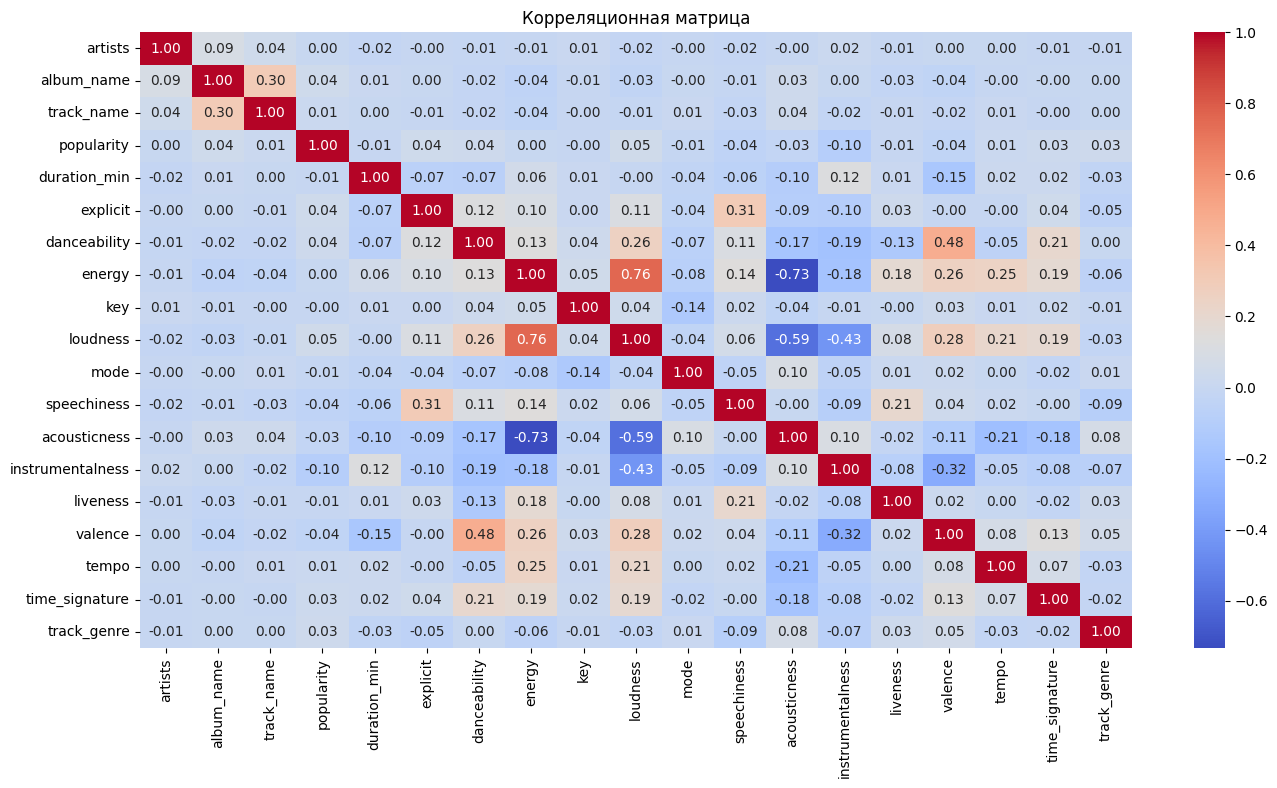

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

**Выводы по корелляционной матрице**

1. Популярность (popularity):
* Сильно положительная корреляция с energy (0.76). Это означает, что более энергичные треки имеют тенденцию быть популярнее.
* Умеренная положительная корреляция с loudness (0.59). Это указывает на то, что громкость тоже может быть фактором популярности.
* Незначительная или почти отсутствующая связь с такими характеристиками, как duration_min, danceability, explicit и valence. Это может означать несущественность влияния этих факторов на популярность.

2. Энергия (energy):
* Высокая положительная корреляция с loudness (0.76), что логично, так как более энергичные треки обычно звучат громче.
* Умеренно отрицательная корреляция с acousticness (-0.73). Это указывает на то, что акустические треки менее энергичны.

3. Акустичность (acousticness):
* Отрицательная корреляция с loudness (-0.59) и energy (-0.73). Это можно объяснить тем, что акустические треки обычно более мягкие и менее громкие.
* Незначительная связь с остальными характеристиками.

4. Показатель привлекательности (valence):
* Умеренная положительная корреляция с danceability (0.48), это означает, что танцевальные треки часто вызывают больше положительных эмоций.
* Слабая положительная корреляция с energy (0.28).
 
5. Инструментальность (instrumentalness):
* Умеренная отрицательная корреляция с energy (-0.43) и loudness (-0.43). Это означает, что треки с высоким уровнем инструментальности, как правило, менее громкие и энергичные.
 
6. Громкость (loudness):
* Сильная корреляции с energy (0.76) и слабая положительную корреляцию с danceability (0.25), что может означать, что громкие треки чаще подходят для танцев.

7. Красноречивость (speechiness)
* Слабая положительная корреляция (0.31) с explicit может означать, что красноречивые треки часто являются откровенными.

**Общие выводы**

1. Популярность трека в основном зависит от таких характеристик, как энергия, громкость и акустичность, причём энергичные и громкие треки оказываются более популярными.

2. Акустические и инструментальные треки имеют тенденцию быть менее энергичными и громкими, что может снижать их популярность.

3. Характеристики, такие как tempo, speechiness и time_signature, имеют слабую или отсутствующую корреляцию с популярностью.

# Анализ и гипотезы

Гипотеза - энергичность трека может сильно влиять на его популярность т.к. большинство людей не любят слишком спопойные песни
Рассмотрим связь между энергичностью и популярностью трека

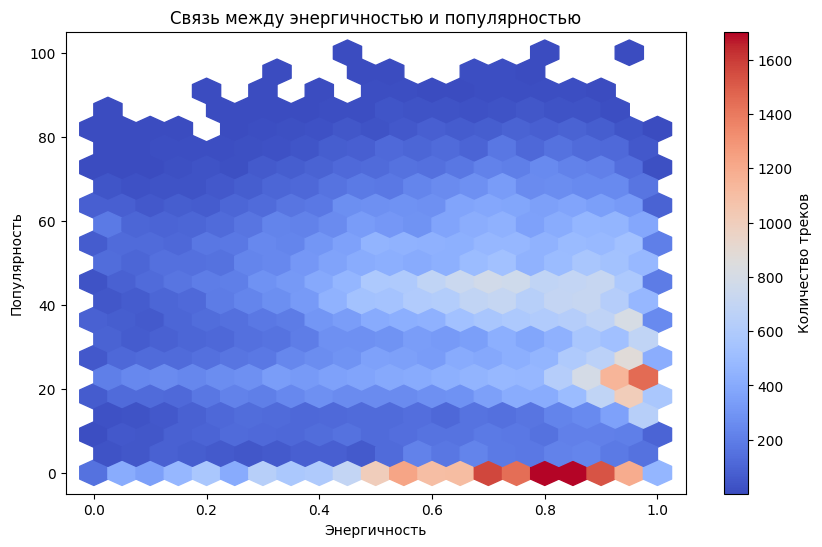

In [20]:
plt.figure(figsize=(10, 6))
plt.hexbin(x=df['energy'], y=df['popularity'], gridsize=20, cmap="coolwarm", mincnt=1)
plt.title('Связь между энергичностью и популярностью')
plt.xlabel('Энергичность')
plt.ylabel('Популярность')
plt.colorbar(label='Количество треков')
plt.show()

Можно заметить большое количество треков  с энергичностью, близкой к единице, и нулевой популярностью.
Это может быть связано с тем, что в датасете много треков с 0 популярностью, а средняя энергирчность находится на уровне 0,65
Также можно заметить, что треки с высокой энергичностью в среднем более популярны

In [21]:
df["energy"].describe()

count    113999.000000
mean          0.641383
std           0.251530
min           0.000000
25%           0.472000
50%           0.685000
75%           0.854000
max           1.000000
Name: energy, dtype: float64

Рассмотрим плотность распределения между громкостью трека и его популярностью

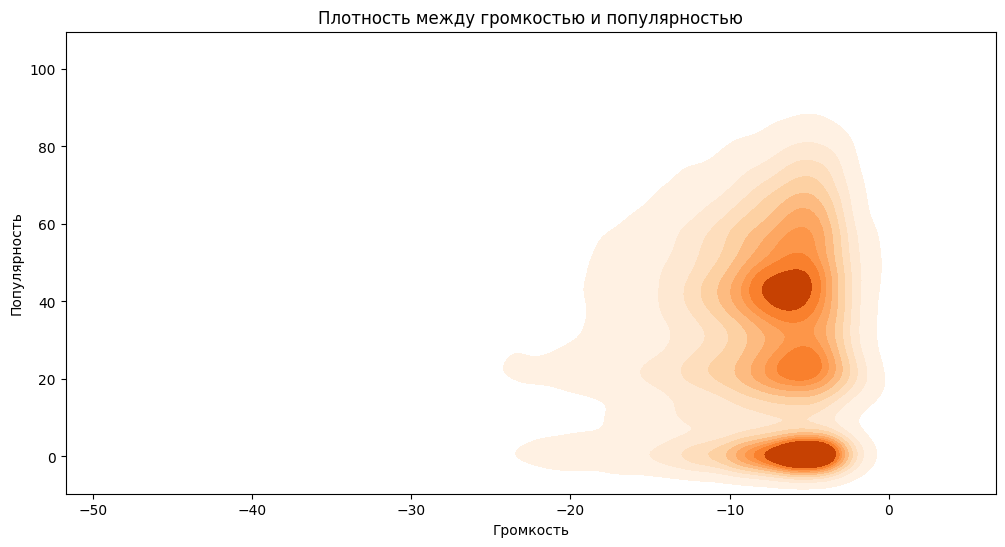

In [22]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='loudness', y='popularity', cmap='Oranges', fill=True)
plt.title('Плотность между громкостью и популярностью')
plt.xlabel('Громкость')
plt.ylabel('Популярность')
plt.show()

Видим, что почти все треки находятся в громкости от -20 до 0. Основное скопление находится в диапазоне от -10 до 0.
При этом в самом популярном диапазоне находятся как популярные, так и непопулярные треки, не уверен, что стоит сделать с этой информацией

Гипотеза: слишком длинные треки являются менее популярными, большим спросом обладают треки средней длины
Рассмотрим связь между популярностью трека и его длительностью

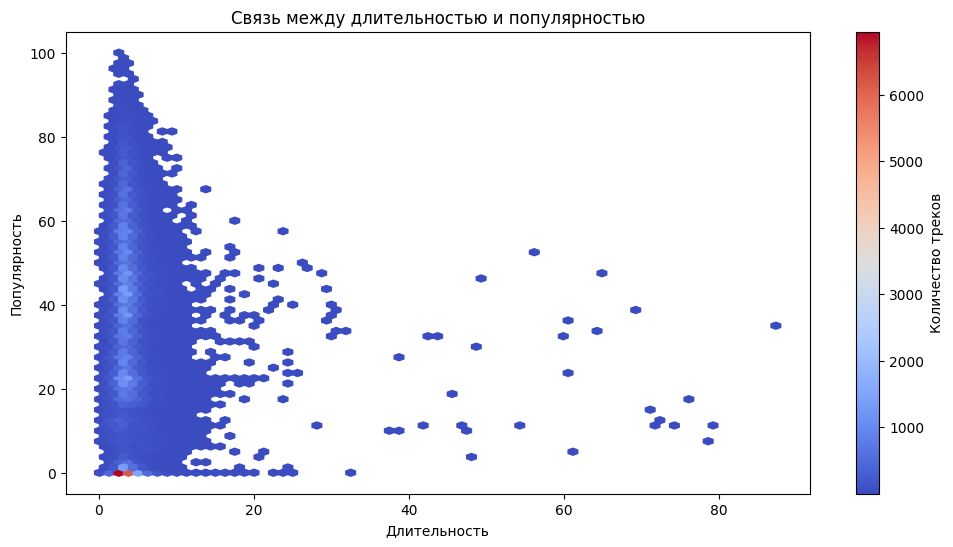

In [23]:
plt.figure(figsize=(12, 6))
plt.hexbin(x=df['duration_min'], y=df['popularity'], gridsize=70, cmap="coolwarm", mincnt=1)
plt.title('Связь между длительностью и популярностью')
plt.xlabel('Длительность')
plt.ylabel('Популярность')
plt.colorbar(label='Количество треков')
plt.show()

Да, почти все популярные треки находятся в диапазоне до 10 минут
Самые популярные треки имеют небольшую разницу в продолжительности

Затем рассмотрим связь между duration_ms, danceability, valence и popularity

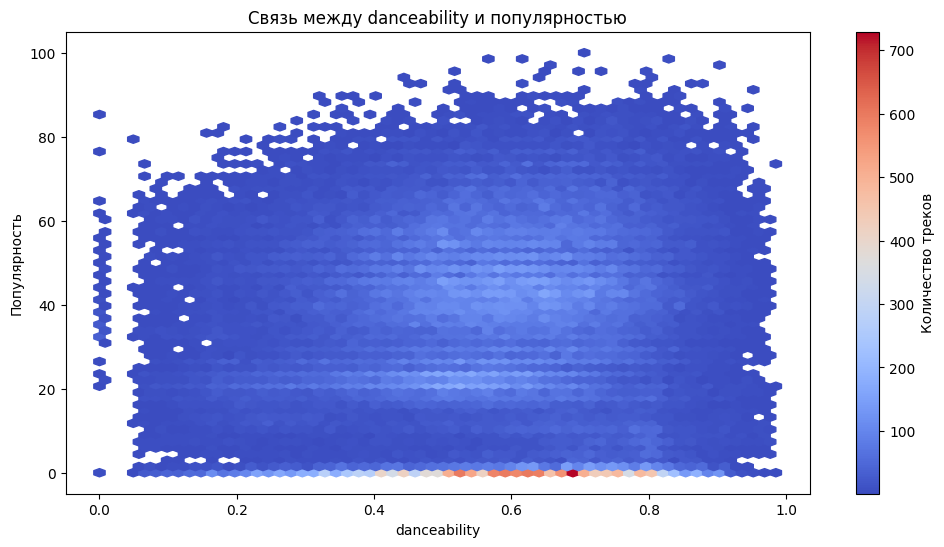

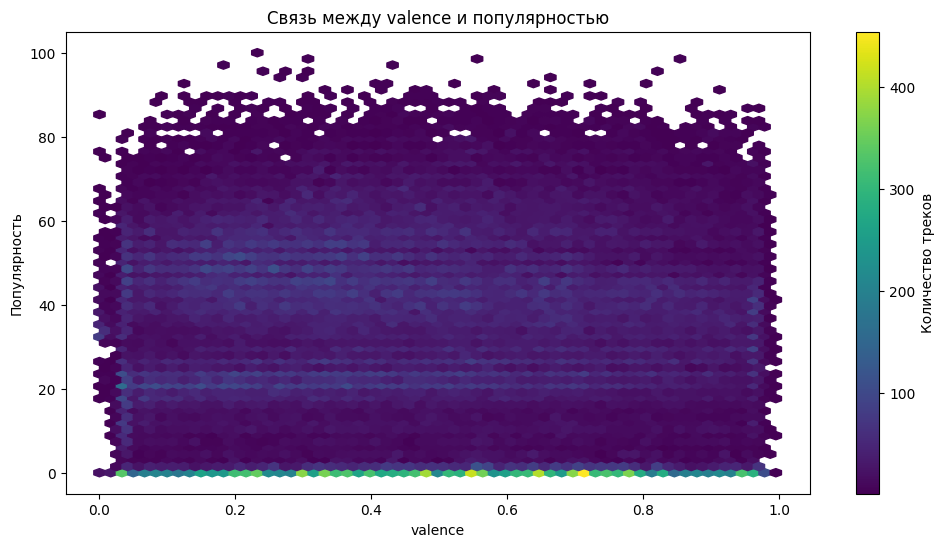

In [24]:
# Список колонок для анализа
columns = ['danceability', 'valence']
# Цветовые карты для каждого графика
cmap_list = ['coolwarm', 'viridis']

# Создание графиков
for i, col in enumerate(columns):
    plt.figure(figsize=(12, 6))
    plt.hexbin(x=df[col], y=df['popularity'], gridsize=60, cmap=cmap_list[i], mincnt=1)
    plt.title(f'Связь между {col} и популярностью')
    plt.xlabel(col)
    plt.ylabel('Популярность')
    plt.colorbar(label='Количество треков')
    plt.show()

Да, корреляция незначительная, яркие выбросы присутствуют только на 0 популярности

Гипотеза - откровенные треки более популярные, т.к. оказывают эмоциональное возденйствие на слушателя

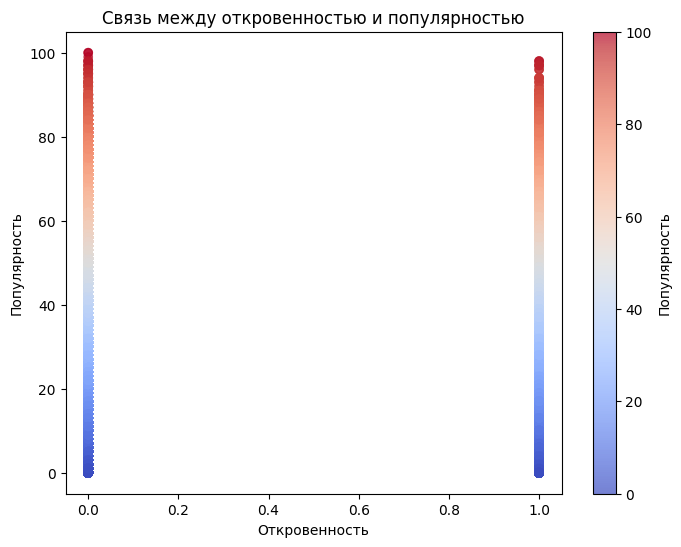

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df['explicit'], df['popularity'], c=df['popularity'], cmap='coolwarm', alpha=0.7)
plt.title('Связь между откровенностью и популярностью')
plt.xlabel('Откровенность')
plt.ylabel('Популярность')
plt.colorbar(label='Популярность')
plt.show()

Гипотеза оказалась не верной, данные идентичны, признак можно удалить

# Выводы по анализу

Есть переменные, которые не влияют на целевую переменную. Популярные треки имеют продолжительность меньше 10

# Feature Engineering

Большое количество признаков может негативно сказаться на обучение моделей
Уберем признаки, которые не коррелируют с целевой переменной

In [26]:
df = df.drop(columns=['artists', 'energy', 'key'],axis=1)

Добавим признак длительности трека. Из анализа мы заметили что боольшинство треков находятся в диапазоне от 0 до 10 минут
А самые популярные находятся в районе 5 минут

**Поэксперементировал с разделением на категории**
* Лучшая комбинация не закомментирована

In [27]:
df['duration_category'] = df['duration_min'].apply(
    lambda x: 2 if x <= 6 else (1 if x <= 10 else 0)
)
# df['duration_category'] = df['duration_min'].apply(
#     lambda x: 1 if x <= 6 else 0
# )
# df['duration_category'] = df['duration_min'].apply(
#     lambda x: 2 if x <= 7 else (1 if x <= 10 else 0)
# )
# df['duration_category'] = df['duration_min'].apply(
#     lambda x: 2 if x <= 8 else (1 if x <= 10 else 0)
# )
# df['duration_category'] = df['duration_min'].apply(
#     lambda x: 2 if x <= 6 else (1 if x <= 11 else 0)
# )


Проверим, что все записалось верно

In [28]:
df['duration_category'].unique()

array([2, 1, 0])

**Повторно рассмотрим корреляцию**
* Что мы ожидаем увидеть - высокую корреляцию duration_category с популярностью и duration_min

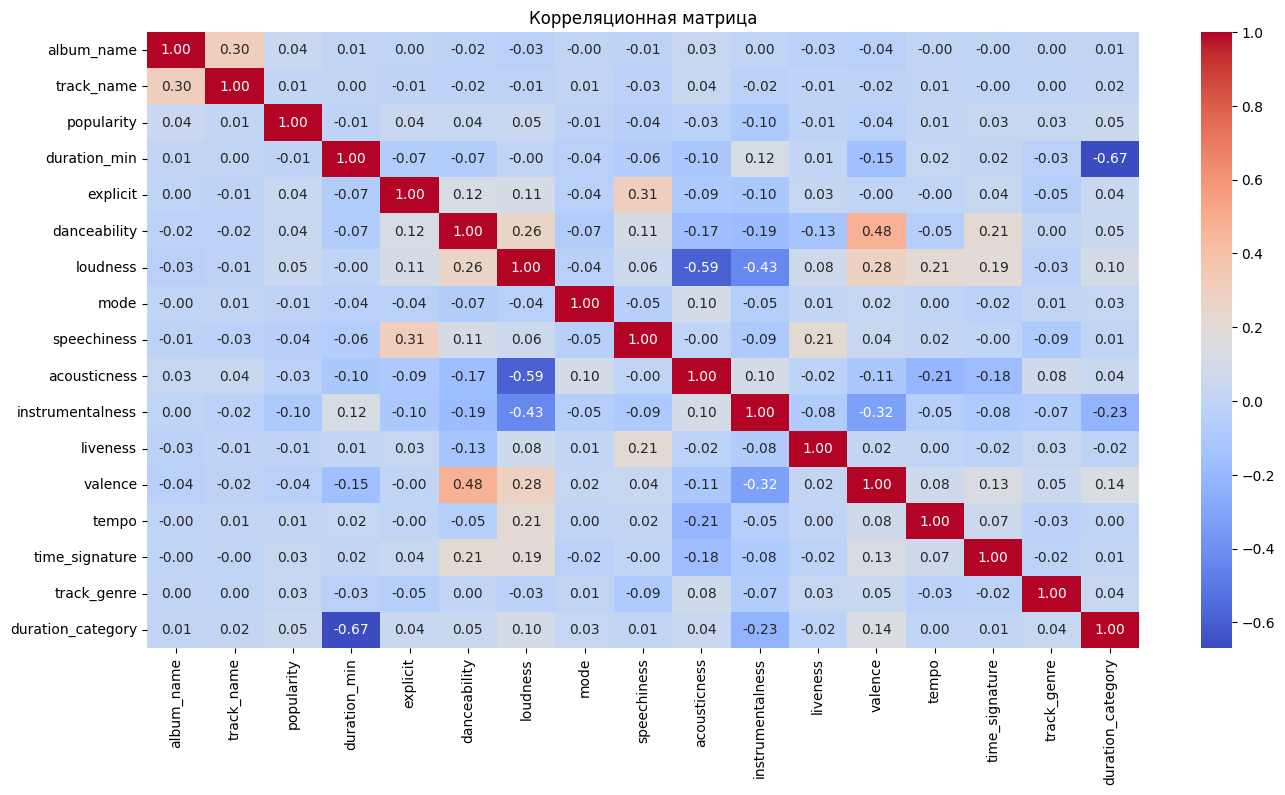

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

In [30]:
df['duration_category'].corr(df['popularity'])

0.05366827651165717

# **Выводы по Feature Engineering** 
1. duration_category стал одним из признаков с самой высокой корреляцией с target
2. Не удивительно, но duration_category имеет высокую корреляцию с duration_min
3. С одной стороны большое количество признаков может негативно повлиять на результаты, с другой стороны корреляция прризнаков с таргетом сравнительно маленькая. Что это значит? если признаков окажется слишком мало, это может негативно повлиять на обучение модели


Сначала попробуем обучить модель без 'duration_min', а после (на всякий случай) с ней

In [31]:
df = df.drop(columns='duration_min',axis=1)

# Эксперементы с моделями для машинного обучения

Сначала нужно импортировать нужные библиотеки

In [32]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

Затем нужно разделить данные на признаки и целевую переменную

In [33]:
X = df.drop(columns=['popularity'])
y = df['popularity']

После разделить данные на обучающую и тестовую выборку

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Затем зададим параметры для кросс-валидации
1. n_splits=5: Делит данные на 5 фолдов (подвыборок). На каждой итерации одна подвыборка используется для тестирования, а остальные 4 — для обучения. Это позволяет более реалевантно оценить модель, так как она тестируется на разных частях данных

3. shuffle=True: Перед разбиением на фолды данные перемешиваются. Это предотвращает возможное влияние порядка данных на качество обучения.

4. random_state=42: Фиксирует начальное состояние генератора случайных чисел. Это делает разбиение повторяемым — при каждом запуске кода данные будут делиться на фолды одинаково.

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Линейная модель

In [36]:
print("Линейная модель")
lin_reg = LinearRegression()
# Кросс-валидация для линейной модели с метрикой R^2
scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=kfold)
print(f"Средний R^2 на кросс-валидации: {scores.mean():.4f}")

# Обучение модели на тренировочной выборке
lin_reg.fit(X_train, y_train)
# Предсказания на тестовой выборке
y_pred_lin = lin_reg.predict(X_test)
# Оценка качества модели на тестовой выборке
print(f"R^2 на тестовой выборке: {r2_score(y_test, y_pred_lin):.4f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_lin):.4f}\n")

Линейная модель
Средний R^2 на кросс-валидации: 0.0288
R^2 на тестовой выборке: 0.0248
MSE на тестовой выборке: 483.7922



Анализ:
* Линейная модель показывает низкий R^2 как на кросс-валидации, так и на тестовой выборке,
что говорит о неспособности этой модели уловить сложные закономерности в данных.

# Дерево решений

In [37]:
print("Дерево решений")
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# GridSearch для подбора лучших гиперпараметров дерева решений
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid, scoring='r2', cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Находим лучшую модель и оцениваем её
print("Лучшие параметры для дерева решений:", grid_search.best_params_)
best_tree = grid_search.best_estimator_

# Предсказания и оценка качества
y_pred_dt = best_tree.predict(X_test)
print(f"R^2 на тестовой выборке: {r2_score(y_test, y_pred_dt):.4f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_dt):.4f}\n")

Дерево решений
Лучшие параметры для дерева решений: {'max_depth': 10, 'min_samples_split': 5}
R^2 на тестовой выборке: 0.1921
MSE на тестовой выборке: 400.7698



Анализ:
* Дерево решений показывает заметно лучшее качество, чем линейная модель, однако результат R^2 на тестовой выборке всё ещё оставляет желать лучшего, модель может быть склонна к переобучению на тренировочных данных.

# Модификаця градиентного бустинга (CatBoost)

In [38]:
# CatBoost
print("CatBoost")
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000]
}

# GridSearch для CatBoost
catboost_reg = CatBoostRegressor(random_state=42, verbose=0)
grid_search = GridSearchCV(estimator=catboost_reg, param_grid=param_grid, scoring='r2', cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Находим лучшую модель и оцениваем её
print("Лучшие параметры для CatBoost:", grid_search.best_params_)
best_catboost = grid_search.best_estimator_

# Предсказания и оценка качества
y_pred_catboost = best_catboost.predict(X_test)
print(f"R^2 на тестовой выборке: {r2_score(y_test, y_pred_catboost):.4f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_catboost):.4f}\n")

CatBoost
Лучшие параметры для CatBoost: {'depth': 10, 'iterations': 1000, 'learning_rate': 0.1}
R^2 на тестовой выборке: 0.5760
MSE на тестовой выборке: 210.3248



Анализ:
* CatBoost значительно превосходит линейную модель и дерево решений как по R^2, так и по MSE, это объясняется способностью модели эффективно работать с табличными данными и учётом нелинейных зависимостей.

# Нейронная сеть

In [39]:
# Нейронная сеть (Keras)
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=128, step=32), activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

print("Нейронная сеть")
tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='spotify_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшие гиперпараметры: {best_hps.values}")

# Создаем и обучаем модель с оптимальными гиперпараметрами
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)
y_pred_nn = best_model.predict(X_test).flatten()  # Преобразование предсказаний в одномерный массив
print(f"R^2 на тестовой выборке: {r2_score(y_test, y_pred_nn):.4f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_nn):.4f}\n")

Trial 10 Complete [00h 01m 50s]
val_mse: 575.0376790364584

Best val_mse So Far: 520.38037109375
Total elapsed time: 00h 16m 34s
Лучшие гиперпараметры: {'units_1': 128, 'units_2': 16}
Epoch 1/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 936270.1875 - mse: 936270.1875 - val_loss: 551.9148 - val_mse: 551.9148
Epoch 2/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 610.0414 - mse: 610.0414 - val_loss: 1897.7739 - val_mse: 1897.7739
Epoch 3/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 968.0337 - mse: 968.0337 - val_loss: 815.4961 - val_mse: 815.4961
Epoch 4/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1240.8331 - mse: 1240.8331 - val_loss: 703.4806 - val_mse: 703.4806
Epoch 5/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 989.6901 - mse: 989.6901 - val_loss: 938.5245 - val_mse: 938.5245
Epoch 6/10
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 797.7501 - mse: 797.7501 - val_loss: 559.4257 - val_mse: 559.4257
Epoch 7/10
2565/2565 ━━━━━━━━━━━━━━━━━

Анализ:
* Нейронная сеть показывает плохой результат как на тренировке, так и на тесте.
* Скорее всего, архитектура сети не соответствует данным для эффективного обучения нейронной сети.

In [40]:
# Итоги
print("Итоги:")
print(f"Линейная модель: R^2 = {r2_score(y_test, y_pred_lin):.4f}, MSE = {mean_squared_error(y_test, y_pred_lin):.4f}")
print(f"Дерево решений: R^2 = {r2_score(y_test, y_pred_dt):.4f}, MSE = {mean_squared_error(y_test, y_pred_dt):.4f}")
print(f"CatBoost: R^2 = {r2_score(y_test, y_pred_catboost):.4f}, MSE = {mean_squared_error(y_test, y_pred_catboost):.4f}")
print(f"Нейронная сеть: R^2 = {r2_score(y_test, y_pred_nn):.4f}, MSE = {mean_squared_error(y_test, y_pred_nn):.4f}")

Итоги:
Линейная модель: R^2 = 0.0248, MSE = 483.7922
Дерево решений: R^2 = 0.1921, MSE = 400.7698
CatBoost: R^2 = 0.5760, MSE = 210.3248
Нейронная сеть: R^2 = -0.1502, MSE = 570.6206


In [41]:
# Кросс-валидация для лучшей модели (CatBoost)
print("Кросс-валидация для CatBoost")
best_catboost = CatBoostRegressor(
    depth=10,
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)

# Кросс-валидация на 5 фолдов
cv_catboost_r2 = cross_val_score(best_catboost, X_train, y_train, cv=kfold, scoring='r2')
cv_catboost_mse = -cross_val_score(best_catboost, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Итоговые результаты
print(f"Средний R^2 на 5 фолдах: {cv_catboost_r2.mean():.4f}")
print(f"Средний MSE на 5 фолдах: {cv_catboost_mse.mean():.4f}")
print(f"Стандартное отклонение R^2: {cv_catboost_r2.std():.4f}")
print(f"Стандартное отклонение MSE: {cv_catboost_mse.std():.4f}")

Кросс-валидация для CatBoost
Средний R^2 на 5 фолдах: 0.5597
Средний MSE на 5 фолдах: 219.1891
Стандартное отклонение R^2: 0.0048
Стандартное отклонение MSE: 2.4686


# Итоговый вывод
В результате анализа были рассмотрены несколько подходов к построению моделей для предсказания целевой переменной. Каждый из подходов показал различные результаты и дал ценные инсайты о данных.

**Линейная модель:**
* Линейная регрессия оказалась неспособной уловить сложные зависимости в данных. Средний R^2 на кросс-валидации был низким, что подтвердилось и на тестовой выборке. Ошибки предсказания оказались значительными, что делает данный метод неподходящим для задачи с нелинейными зависимостями.

**Дерево решений:**
* После подбора гиперпараметров (максимальная глубина и минимальное количество объектов для разбиения), дерево решений показало улучшение качества по сравнению с линейной моделью. R^2 на тестовой выборке оказался выше, а среднеквадратичная ошибка снизилась. Однако дерево решений склонно к переобучению, что ограничивает его применимость на сложных данных.

**CatBoost:**
* CatBoost продемонстрировал лучшие результаты среди всех протестированных моделей. Подбор гиперпараметров позволил достичь устойчивых метрик. R^2 на тестовой выборке был значительно выше, а MSE — самым низким среди всех моделей. Алгоритм показал высокую способность обрабатывать нелинейные зависимости, что делает его предпочтительным выбором.

**Нейронная сеть:**
* Несмотря на настройку архитектуры через Keras Tuner, нейронная сеть продемонстрировала самые слабые результаты. R^2 оказался ниже, чем у CatBoost, даже дерева решений и даже линейной модели, а MSE — значительно выше. Вероятной причиной может быть неоптимальная архитектура модели.
* Для улучшения потребуются более сложная структура сети.

**Выводы:**
* На основе анализа CatBoost является наиболее подходящей моделью для данной задачи. Он показал высокие результаты по всем ключевым метрикам, продемонстрировал устойчивость и способность учитывать сложные зависимости в данных.
* Нейронная сеть оказалась самой слабой, она требует значительных доработок для достижения конкурентоспособных результатов.